## Data Cleaning & Pre-processing

In [1]:
#To make a cnx between pyspark & mongodb (our DataLake)

In [37]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, to_date, year
from pyspark.sql.functions import split, array_distinct, concat_ws

spark = SparkSession.builder \
    .appName("brevet") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0") \
    .getOrCreate()

mongo_ip = "mongodb://127.0.0.1:27017/"
db_name = "Bigdata-Proj" 
collection_name = "GP-Data"  

df = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", "mongodb://127.0.0.1:27017/Bigdata-Proj.GP-Data") \
    .load()


df.printSchema()

root
 |-- Abstract: string (nullable = true)
 |-- Assignee: string (nullable = true)
 |-- Claims: string (nullable = true)
 |-- Classification: string (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Country Name: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Filing Date: string (nullable = true)
 |-- Inventors: string (nullable = true)
 |-- Patent Application Number: string (nullable = true)
 |-- Patent ID: string (nullable = true)
 |-- Patent Number: string (nullable = true)
 |-- Patent PDF URL: string (nullable = true)
 |-- Priority Date: timestamp (nullable = true)
 |-- References: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [38]:
import pandas as pd

# Convertir le DataFrame Spark en DataFrame pandas
pandas_df = df.toPandas()

# Afficher le DataFrame pandas
pandas_df.head(6)


Abstract  \
0  A mobile energy storage apparatus comprised of...   
1  A vehicle charging interface unit for connecti...   
2  A controller of an electric vehicle is disclos...   
3  本公开涉及基于电气化车辆电池中的锂镀覆检测的车辆控制。一种包括具有至少一个电池单元的牵引电池...   
4  System are described that include an energy st...   
5  Methods of and apparatus for removing heat gen...   

                         Assignee  \
0                      Individual   
1                  Volvo Car Corp   
2           Auto Motive Power Inc   
3    Ford Global Technologies LLC   
4  Johnson Controls Technology Co   
5    Webasto Charging Systems Inc   

                                              Claims Classification  \
0  1. A system, comprising:\na movable object tha...              B   
1  1. A vehicle charging interface unit for conne...    B60L11/1818   
2  1. A controller comprising:\na BMS LV module c...              B   
3  1.一种车辆，包括：, 牵引电池，具有多个电池单元；, 控制器，与所述牵引电池通信，并且被配...              B   
4  1. An energy source system, comprising:\na hou...              H   
5  1. A fan box interposed between a set of batte...              B   

  Country Code   Country Name  \
0           US  United States   
1           US  United States   
2           US  United States   
3           CN          China   
4           US  United States   
5           US  United States   

                                         Description Filing Date  \
0  The present disclosure pertains to apparatus, ...  2020-08-11   
1  The present disclosure relates to a vehicle ch...  2019-04-23   
2  This relates to systems for electric vehicles ...  2022-10-04   
3                                            Unknown  2022-01-14   
4  This Application is a Divisional Application o...  2018-12-18   
5  This application is a continuation of U.S. pat...  2019-06-04   

                                           Inventors  \
0  Stephen G. Johnsen, Ronald L. Easley, Kenneth ...   
1                                     Bjorn Scherdin   
2  Anil Paryani, Mike Hibbard, Vardan Markosyan, ...   
3             何川, 杰弗里·考埃尔, 李峰, 王旭, 毛睿齐, 布兰登·斯威舍, 陈海岩   
4     Thomas M. Watson, Junwei Jiang, Perry M. Wyatt   
5              Blake E. Dickinson, Larry Hayashigawa   

  Patent Application Number     Patent ID   Patent Number  \
0             US:15/885,360  US10737583B2     US:10737583   
1             US:15/688,999  US10266058B2     US:10266058   
2             US:16/813,290  US11458856B2     US:11458856   
3        CN:201710041216.6A  CN107009905B  CN:107009905:B   
4             US:15/059,103  US10158152B2     US:10158152   
5             US:15/441,354  US10308490B2     US:10308490   

                                      Patent PDF URL Priority Date  \
0  https://patentimages.storage.googleapis.com/6d...    2020-08-11   
1  https://patentimages.storage.googleapis.com/6a...    2019-04-23   
2  https://patentimages.storage.googleapis.com/4c...    2022-10-04   
3  https://patentimages.storage.googleapis.com/3c...    2022-01-14   
4  https://patentimages.storage.googleapis.com/11...    2018-12-18   
5  https://patentimages.storage.googleapis.com/2b...    2019-06-04   

                                          References  Status  \
0  US:4902955, US:5111127, US:5559420, US:6140799...  Active   
1  US:3956573, US:4473265, US:4968856, US:4997103...  Active   
2   GB:2520556:A, JP:2017136982:A, US:20200014240:A1  Active   
3   CN:103072492:A, WO:2014125215:A1, CN:203267806:U  Active   
4  US:4047088, WO:1984001475:A1, US:4962462, US:5...  Active   
5  US:5082075, US:5490572, US:5204609, US:5496389...  Active   

                                               Title  \
0  Mobile variable power system and method \n          
1  Vehicle charging interface unit, a system for ...   
2  Combined BMS, charger, and DC-DC in electric v...   
3                    基于电气化车辆电池中的锂镀覆检测的车辆控制 \n          
4  Energy source system having multiple energy st...   
5  Integrated battery unit with cooling and prote...   

                           _id

In [138]:
# Convertir les colonnes de date en format de date approprié
df_cleaned = df.withColumn('Filing Date', to_date(col('Filing Date')))
df_cleaned = df.withColumn('Priority Date', to_date(col('Priority Date')))

In [139]:
# To verify the columns with NaN values
from pyspark.sql.functions import isnan, col


for col_name in df_cleaned.columns:
    if col_name != 'Priority Date' and col_name != '_id':
        nan_rows = df_cleaned.filter(isnan(col(col_name)))
        print(f"Nombre de lignes avec NaN dans la colonne '{col_name}': {nan_rows.count()}")

Nombre de lignes avec NaN dans la colonne 'Abstract': 0
Nombre de lignes avec NaN dans la colonne 'Assignee': 0
Nombre de lignes avec NaN dans la colonne 'Claims': 0
Nombre de lignes avec NaN dans la colonne 'Classification': 0
Nombre de lignes avec NaN dans la colonne 'Country Code': 0
Nombre de lignes avec NaN dans la colonne 'Country Name': 0
Nombre de lignes avec NaN dans la colonne 'Description': 0
Nombre de lignes avec NaN dans la colonne 'Filing Date': 0
Nombre de lignes avec NaN dans la colonne 'Inventors': 0
Nombre de lignes avec NaN dans la colonne 'Patent Application Number': 0
Nombre de lignes avec NaN dans la colonne 'Patent ID': 0
Nombre de lignes avec NaN dans la colonne 'Patent Number': 0
Nombre de lignes avec NaN dans la colonne 'Patent PDF URL': 0
Nombre de lignes avec NaN dans la colonne 'References': 0
Nombre de lignes avec NaN dans la colonne 'Status': 0
Nombre de lignes avec NaN dans la colonne 'Title': 0


In [140]:
from pyspark.sql.functions import isnan, col

# Vérifier la colonne '_id' pour les NaN
# Vérifier la colonne '_id' pour les valeurs nulles
nan_rows_id = df_cleaned.filter(col('_id').isNull())
print(f"Nombre de lignes avec des valeurs nulles dans la colonne '_id': {nan_rows_id.count()}")

# Vérifier la colonne 'Priority Date' pour les valeurs nulles
nan_rows_priority_date = df_cleaned.filter(col('Priority Date').isNull())
print(f"Nombre de lignes avec des valeurs nulles dans la colonne 'Priority Date': {nan_rows_priority_date.count()}")


Nombre de lignes avec des valeurs nulles dans la colonne '_id': 0
Nombre de lignes avec des valeurs nulles dans la colonne 'Priority Date': 0


In [141]:
# Remplacer les valeurs "Not available" dans la colonne 'Filing Date' par la valeur de la colonne 'Priority Date'

from pyspark.sql.functions import when

df_cleaned = df_cleaned.withColumn('Filing Date', when(col('Filing Date') == 'Not available', col('Priority Date')).otherwise(col('Filing Date')))


In [142]:
import pandas as pd

# Convertir le DataFrame PySpark en DataFrame Pandas
df_pandas = df_cleaned.toPandas()

# Afficher le DataFrame Pandas sous forme de tableau
df_pandas.head(20)


Abstract  \
0   A mobile energy storage apparatus comprised of...   
1   A vehicle charging interface unit for connecti...   
2   A controller of an electric vehicle is disclos...   
3   本公开涉及基于电气化车辆电池中的锂镀覆检测的车辆控制。一种包括具有至少一个电池单元的牵引电池...   
4   System are described that include an energy st...   
5   Methods of and apparatus for removing heat gen...   
6   An electric vehicle includes a battery, a char...   
7   A vehicle includes an electric motor; a batter...   
8   本发明提出了在电气化车辆(EV)的能量储存设备(ESD)和AC或DC外部负载(例如电网、电气...   
9   A powertrain system for a vehicle includes an ...   
10  A battery for an electric vehicle is disclosed...   
11  This patent application is directed to thermal...   
12  A vehicle mutual-charging system and a chargin...   
13  本申请提供一种电动汽车驱动系统、驱动电路及电动汽车电池加热方法。所述电动车驱动系统包括第一控...   
14  本公开涉及使用具有集成的电压转换器的继电器的车辆电力分配。一种车辆电力分配系统包括电池、车辆...   
15  一种新能源汽车快换型通用动力电池，电池本体（1）上设置有快换接口、接口凹陷结构、独立液态温控...   
16  Systems and methods for measuring voltage of a...   
17  本发明公开了一种基于移动客户端的电动汽车动力电池预热系统及其预热方法，包括以下步骤：电动汽车...   
18  전기 차량용 전원 시스템, 전기 차량, 및 전원 배터리를 충전하기 위한 방법이 제공...   
19  The present disclosure relates to a battery sy...   

                                    Assignee  \
0                                 Individual   
1                             Volvo Car Corp   
2                      Auto Motive Power Inc   
3               Ford Global Technologies LLC   
4             Johnson Controls Technology Co   
5               Webasto Charging Systems Inc   
6                         Honda Motor Co Ltd   
7                        Yamaha Motor Co Ltd   
8               Ford Global Technologies LLC   
9                      KPIT Technologies Ltd   
10                    Faraday and Future Inc   
11                  Quantumscape Battery Inc   
12                                BYD Co Ltd   
13                       Tsinghua University   
14              Ford Global Technologies LLC   
15                                       王宁豪   
16              Ford Global Technologies LLC   
17            Sichuan Yema Automobile Co Ltd   
18                             비와이디 컴퍼니 리미티드   
19  Hexagon Purus North America Holdings Inc   

                                               Claims Classification  \
0   1. A system, comprising:\na movable object tha...              B   
1   1. A vehicle charging interface unit for conne...    B60L11/1818   
2   1. A controller comprising:\na BMS LV module c...              B   
3   1.一种车辆，包括：, 牵引电池，具有多个电池单元；, 控制器，与所述牵引电池通信，并且被配...              B   
4   1. An energy source system, comprising:\na hou...              H   
5   1. A fan box interposed between a set of batte...              B   
6   1. An electric vehicle having a battery charge...              B   
7   1. A vehicle comprising:\nan electric motor th...    B60L11/1816   
8   1.一种便携式电气化车辆能量传递系统，包含：, 电气化车辆；以及, 电气化车辆能量传递装置，...              B   
9   1. A powertrain system for a vehicle comprisin...              B   
10  1. A method of assembling a vehicle battery fr...              H   
11  1. A thermal management system for a vehicle, ...              B   
12  1. An electric vehicle for mutual-charging, co...              B   
13  1.一种驱动电路（100），其特征在于，包括：, 供电单元（10），包括第一电池组（11）和...              B   
14  1.一种车辆电力分配系统，包括：, 电池，具有标称电压；, 负载，具有小于标称电压的额定电压...              B   
15  一种新能源汽车快换型通用动力电池，包括电池本体，所述的电池本体上设置有用于快速拆装的快换接口...              B   
16  1. A vehicle, comprising:\na traction battery ...              B   
17  1.一种基于移动客户端的电动汽车动力电池预热方法，其特征在于包括以下步骤：, 步骤一：电动汽...              H   
18  전기 차량용 전원 시스템에 있어서,전원 배터리의 제1 단자에 접속되는 제1 직류 단...              B   
19  1. A battery assembly for an electric vehicle,...              B   

   Country Code   Country Name  \
0            US  United States   
1            US  United States   
2            US  United States   
3            CN          China   
4            US  United States   
5            US  United States   
6            US  United States   
7            US  United States   
8            CN    

In [146]:
from pyspark.sql.functions import col

# Liste des colonnes à remplir avec "Unknown"
columns_to_fill = ['Claims', 'Classification', 'Description', 'Patent Number', 'Patent PDF URL', 'References', 'Status']

# Remplacer les valeurs "NaN" par "Unknown" dans les colonnes spécifiées
for col_name in columns_to_fill:
    df_cleaned = df_cleaned.withColumn(col_name, when(col(col_name) == "NaN", "Unknown").otherwise(col(col_name)))




In [147]:

# Convertir le DataFrame PySpark en DataFrame Pandas
df_pandas = df_cleaned.toPandas()

# Afficher le DataFrame Pandas sous forme de tableau
df_pandas.head(20)


Abstract  \
0   A mobile energy storage apparatus comprised of...   
1   A vehicle charging interface unit for connecti...   
2   A controller of an electric vehicle is disclos...   
3   本公开涉及基于电气化车辆电池中的锂镀覆检测的车辆控制。一种包括具有至少一个电池单元的牵引电池...   
4   System are described that include an energy st...   
5   Methods of and apparatus for removing heat gen...   
6   An electric vehicle includes a battery, a char...   
7   A vehicle includes an electric motor; a batter...   
8   本发明提出了在电气化车辆(EV)的能量储存设备(ESD)和AC或DC外部负载(例如电网、电气...   
9   A powertrain system for a vehicle includes an ...   
10  A battery for an electric vehicle is disclosed...   
11  This patent application is directed to thermal...   
12  A vehicle mutual-charging system and a chargin...   
13  本申请提供一种电动汽车驱动系统、驱动电路及电动汽车电池加热方法。所述电动车驱动系统包括第一控...   
14  本公开涉及使用具有集成的电压转换器的继电器的车辆电力分配。一种车辆电力分配系统包括电池、车辆...   
15  一种新能源汽车快换型通用动力电池，电池本体（1）上设置有快换接口、接口凹陷结构、独立液态温控...   
16  Systems and methods for measuring voltage of a...   
17  本发明公开了一种基于移动客户端的电动汽车动力电池预热系统及其预热方法，包括以下步骤：电动汽车...   
18  전기 차량용 전원 시스템, 전기 차량, 및 전원 배터리를 충전하기 위한 방법이 제공...   
19  The present disclosure relates to a battery sy...   

                                    Assignee  \
0                                 Individual   
1                             Volvo Car Corp   
2                      Auto Motive Power Inc   
3               Ford Global Technologies LLC   
4             Johnson Controls Technology Co   
5               Webasto Charging Systems Inc   
6                         Honda Motor Co Ltd   
7                        Yamaha Motor Co Ltd   
8               Ford Global Technologies LLC   
9                      KPIT Technologies Ltd   
10                    Faraday and Future Inc   
11                  Quantumscape Battery Inc   
12                                BYD Co Ltd   
13                       Tsinghua University   
14              Ford Global Technologies LLC   
15                                       王宁豪   
16              Ford Global Technologies LLC   
17            Sichuan Yema Automobile Co Ltd   
18                             비와이디 컴퍼니 리미티드   
19  Hexagon Purus North America Holdings Inc   

                                               Claims Classification  \
0   1. A system, comprising:\na movable object tha...              B   
1   1. A vehicle charging interface unit for conne...    B60L11/1818   
2   1. A controller comprising:\na BMS LV module c...              B   
3   1.一种车辆，包括：, 牵引电池，具有多个电池单元；, 控制器，与所述牵引电池通信，并且被配...              B   
4   1. An energy source system, comprising:\na hou...              H   
5   1. A fan box interposed between a set of batte...              B   
6   1. An electric vehicle having a battery charge...              B   
7   1. A vehicle comprising:\nan electric motor th...    B60L11/1816   
8   1.一种便携式电气化车辆能量传递系统，包含：, 电气化车辆；以及, 电气化车辆能量传递装置，...              B   
9   1. A powertrain system for a vehicle comprisin...              B   
10  1. A method of assembling a vehicle battery fr...              H   
11  1. A thermal management system for a vehicle, ...              B   
12  1. An electric vehicle for mutual-charging, co...              B   
13  1.一种驱动电路（100），其特征在于，包括：, 供电单元（10），包括第一电池组（11）和...              B   
14  1.一种车辆电力分配系统，包括：, 电池，具有标称电压；, 负载，具有小于标称电压的额定电压...              B   
15  一种新能源汽车快换型通用动力电池，包括电池本体，所述的电池本体上设置有用于快速拆装的快换接口...              B   
16  1. A vehicle, comprising:\na traction battery ...              B   
17  1.一种基于移动客户端的电动汽车动力电池预热方法，其特征在于包括以下步骤：, 步骤一：电动汽...              H   
18  전기 차량용 전원 시스템에 있어서,전원 배터리의 제1 단자에 접속되는 제1 직류 단...              B   
19  1. A battery assembly for an electric vehicle,...              B   

   Country Code   Country Name  \
0            US  United States   
1            US  United States   
2            US  United States   
3            CN          China   
4            US  United States   
5            US  United States   
6            US  United States   
7            US  United States   
8            CN    

In [148]:
#Enregistrer les modifications dans Mongodb 

# Importer la classe DefaultSource
from pyspark.sql import DataFrameWriter

# Écrire les données dans MongoDB
df_cleaned.write.format("com.mongodb.spark.sql.DefaultSource") \
    .mode("append") \
    .option("uri", "mongodb://127.0.0.1:27017/Bigdata-Proj.GP-Data") \
    .save()


## EDA Google Patent

In [12]:
# Cnx part

In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, to_date, year
from pyspark.sql.functions import split, array_distinct, concat_ws

spark = SparkSession.builder \
    .appName("brevet") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0") \
    .getOrCreate()

mongo_ip = "mongodb://127.0.0.1:27017/"
db_name = "Bigdata-Proj" 
collection_name = "GP-Data"  

df = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", "mongodb://127.0.0.1:27017/Bigdata-Proj.GP-Data") \
    .load()


df.printSchema()

root
 |-- Abstract: string (nullable = true)
 |-- Assignee: string (nullable = true)
 |-- Claims: string (nullable = true)
 |-- Classification: string (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Country Name: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Filing Date: string (nullable = true)
 |-- Inventors: string (nullable = true)
 |-- Patent Application Number: string (nullable = true)
 |-- Patent ID: string (nullable = true)
 |-- Patent Number: string (nullable = true)
 |-- Patent PDF URL: string (nullable = true)
 |-- Priority Date: timestamp (nullable = true)
 |-- References: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [2]:
# Affichage  des données
df.show()


+-------------------------------------+------------------------+-------------------------------------+--------------+------------+-------------+-------------------------------------+-----------+--------------------------------+-------------------------+--------------+---------------+--------------------+-------------------+--------------------+--------------------+-------------------------------------+--------------------+
|                             Abstract|                Assignee|                               Claims|Classification|Country Code| Country Name|                          Description|Filing Date|                       Inventors|Patent Application Number|     Patent ID|  Patent Number|      Patent PDF URL|      Priority Date|          References|              Status|                                Title|                 _id|
+-------------------------------------+------------------------+-------------------------------------+--------------+------------+-------------+--

In [3]:
import pandas as pd

# Convertir le DataFrame Spark en DataFrame pandas
pandas_df = df.toPandas()

# Afficher le DataFrame pandas
pandas_df.head(6)


Abstract  \
0  A mobile energy storage apparatus comprised of...   
1  A vehicle charging interface unit for connecti...   
2  A controller of an electric vehicle is disclos...   
3  本公开涉及基于电气化车辆电池中的锂镀覆检测的车辆控制。一种包括具有至少一个电池单元的牵引电池...   
4  System are described that include an energy st...   
5  Methods of and apparatus for removing heat gen...   

                         Assignee  \
0                      Individual   
1                  Volvo Car Corp   
2           Auto Motive Power Inc   
3    Ford Global Technologies LLC   
4  Johnson Controls Technology Co   
5    Webasto Charging Systems Inc   

                                              Claims Classification  \
0  1. A system, comprising:\na movable object tha...              B   
1  1. A vehicle charging interface unit for conne...    B60L11/1818   
2  1. A controller comprising:\na BMS LV module c...              B   
3  1.一种车辆，包括：, 牵引电池，具有多个电池单元；, 控制器，与所述牵引电池通信，并且被配...              B   
4  1. An energy source system, comprising:\na hou...              H   
5  1. A fan box interposed between a set of batte...              B   

  Country Code   Country Name  \
0           US  United States   
1           US  United States   
2           US  United States   
3           CN          China   
4           US  United States   
5           US  United States   

                                         Description Filing Date  \
0  The present disclosure pertains to apparatus, ...  2020-08-11   
1  The present disclosure relates to a vehicle ch...  2019-04-23   
2  This relates to systems for electric vehicles ...  2022-10-04   
3                                            Unknown  2022-01-14   
4  This Application is a Divisional Application o...  2018-12-18   
5  This application is a continuation of U.S. pat...  2019-06-04   

                                           Inventors  \
0  Stephen G. Johnsen, Ronald L. Easley, Kenneth ...   
1                                     Bjorn Scherdin   
2  Anil Paryani, Mike Hibbard, Vardan Markosyan, ...   
3             何川, 杰弗里·考埃尔, 李峰, 王旭, 毛睿齐, 布兰登·斯威舍, 陈海岩   
4     Thomas M. Watson, Junwei Jiang, Perry M. Wyatt   
5              Blake E. Dickinson, Larry Hayashigawa   

  Patent Application Number     Patent ID   Patent Number  \
0             US:15/885,360  US10737583B2     US:10737583   
1             US:15/688,999  US10266058B2     US:10266058   
2             US:16/813,290  US11458856B2     US:11458856   
3        CN:201710041216.6A  CN107009905B  CN:107009905:B   
4             US:15/059,103  US10158152B2     US:10158152   
5             US:15/441,354  US10308490B2     US:10308490   

                                      Patent PDF URL Priority Date  \
0  https://patentimages.storage.googleapis.com/6d...    2020-08-11   
1  https://patentimages.storage.googleapis.com/6a...    2019-04-23   
2  https://patentimages.storage.googleapis.com/4c...    2022-10-04   
3  https://patentimages.storage.googleapis.com/3c...    2022-01-14   
4  https://patentimages.storage.googleapis.com/11...    2018-12-18   
5  https://patentimages.storage.googleapis.com/2b...    2019-06-04   

                                          References  Status  \
0  US:4902955, US:5111127, US:5559420, US:6140799...  Active   
1  US:3956573, US:4473265, US:4968856, US:4997103...  Active   
2   GB:2520556:A, JP:2017136982:A, US:20200014240:A1  Active   
3   CN:103072492:A, WO:2014125215:A1, CN:203267806:U  Active   
4  US:4047088, WO:1984001475:A1, US:4962462, US:5...  Active   
5  US:5082075, US:5490572, US:5204609, US:5496389...  Active   

                                               Title  \
0  Mobile variable power system and method \n          
1  Vehicle charging interface unit, a system for ...   
2  Combined BMS, charger, and DC-DC in electric v...   
3                    基于电气化车辆电池中的锂镀覆检测的车辆控制 \n          
4  Energy source system having multiple energy st...   
5  Integrated battery unit with cooling and prote...   

                           _id

In [4]:
pandas_df.count()

Abstract                     516
Assignee                     516
Claims                       516
Classification               516
Country Code                 516
Country Name                 516
Description                  516
Filing Date                  516
Inventors                    516
Patent Application Number    516
Patent ID                    516
Patent Number                516
Patent PDF URL               516
Priority Date                516
References                   516
Status                       516
Title                        516
_id                          516
dtype: int64

In [5]:
pandas_df.describe(datetime_is_numeric=True)

Priority Date
count                            516
mean   2019-03-07 08:41:37.674418688
min              1993-03-16 00:00:00
25%              2017-10-02 00:00:00
50%              2019-09-05 00:00:00
75%              2021-09-23 12:00:00
max              2024-02-09 00:00:00

In [6]:
df.createOrReplaceTempView("GP")
spark.sql("SELECT * FROM GP ")


DataFrame[Abstract: string, Assignee: string, Claims: string, Classification: string, Country Code: string, Country Name: string, Description: string, Filing Date: string, Inventors: string, Patent Application Number: string, Patent ID: string, Patent Number: string, Patent PDF URL: string, Priority Date: timestamp, References: string, Status: string, Title: string, _id: struct<oid:string>]

## Analyse du nbre de brevets par pays :

In [7]:
# Afficher les valeurs uniques dans la colonne "Country Name"
unique_countries = spark.sql("""
    SELECT DISTINCT `Country Name` FROM GP
""")

# Afficher le résultat
unique_countries.show()


+--------------------+
|        Country Name|
+--------------------+
|European Patent O...|
|       United States|
|               China|
|               Spain|
|         South Korea|
|              Canada|
|               Japan|
|          WIPO (PCT)|
|      United Kingdom|
+--------------------+



+--------------------+-----+
|        Country Name|count|
+--------------------+-----+
|               China|  234|
|       United States|  189|
|         South Korea|   32|
|          WIPO (PCT)|   24|
|               Japan|   15|
|European Patent O...|   14|
|               Spain|    4|
|              Canada|    3|
|      United Kingdom|    1|
+--------------------+-----+



<AxesSubplot: title={'center': 'Nombre de brevets par pays'}, xlabel='Country Name'>

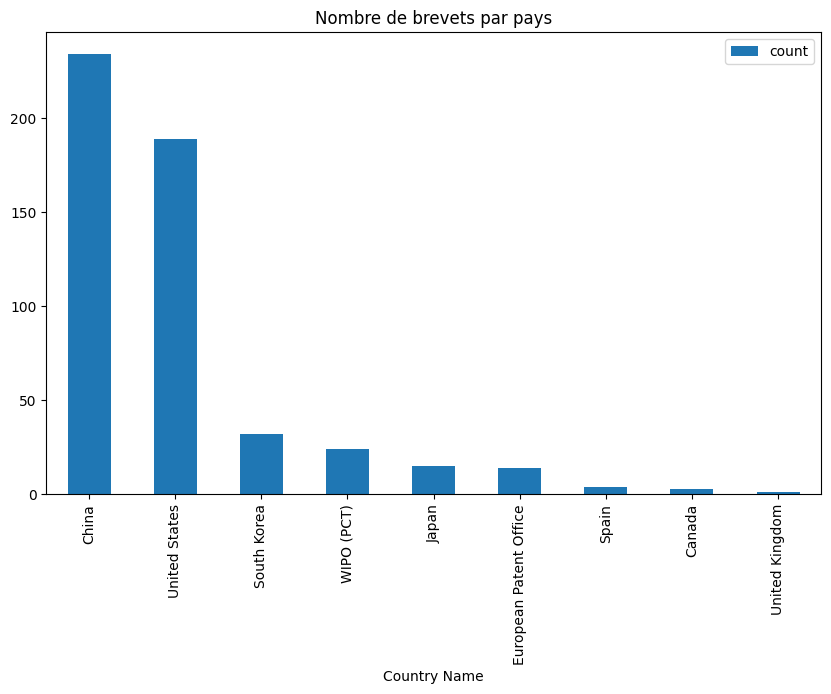

In [8]:
# Analyser le nombre de demandes de brevets par pays à partir de la vue
demandes_par_pays = spark.sql("SELECT `Country Name`, COUNT(*) AS count FROM GP GROUP BY `Country Name` ORDER BY count DESC")

# Afficher le résultat
demandes_par_pays.show()

# Visualisation
demandes_par_pays_df = demandes_par_pays.toPandas()
demandes_par_pays_df.plot(kind='bar', x='Country Name', y='count', figsize=(10, 6), title='Nombre de brevets par pays')


## Analyse des tendances temporelles :

+-----------+-----+
|Filing_Year|count|
+-----------+-----+
|       1993|    1|
|       2002|    2|
|       2005|    1|
|       2007|    1|
|       2008|    3|
|       2009|    1|
|       2010|    4|
|       2011|    3|
|       2012|   10|
|       2013|   24|
|       2014|   15|
|       2015|   13|
|       2016|   30|
|       2017|   36|
|       2018|   60|
|       2019|   82|
|       2020|   77|
|       2021|   40|
|       2022|   59|
|       2023|   49|
+-----------+-----+
only showing top 20 rows



<AxesSubplot: title={'center': 'Évolution du nombre de demandes de brevets au fil du temps'}, xlabel='Filing_Year'>

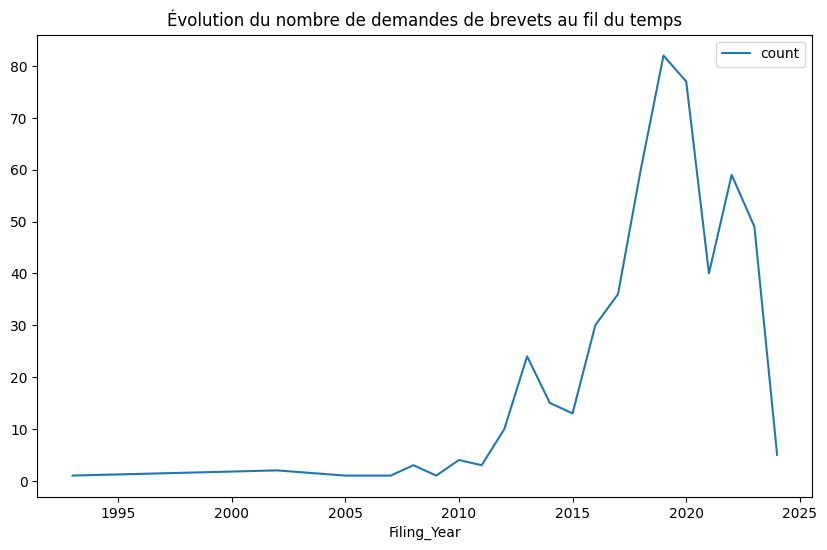

In [9]:
# Extraire l'année de la date de dépôt à partir de la vue
tendances_temporelles = spark.sql("SELECT YEAR(`filing Date`) AS Filing_Year, COUNT(*) AS count FROM GP GROUP BY Filing_Year ORDER BY Filing_Year")

# Afficher le résultat
tendances_temporelles.show()

# Visualisation
tendances_temporelles_df = tendances_temporelles.toPandas()
tendances_temporelles_df.plot(kind='line', x='Filing_Year', y='count', figsize=(10, 6), title='Évolution du nombre de demandes de brevets au fil du temps')


**Augmentation pdt la période du Covid (2019-2020)**

## Analyse des classifications de brevets 

+--------------+-----+
|Classification|count|
+--------------+-----+
|             B|  283|
|             H|  100|
|             Y|   50|
|             G|   29|
|       Unknown|   14|
|   B60L11/1879|    3|
|   B60L11/1822|    3|
|   B60L11/1818|    2|
|   B60L11/1838|    2|
|    B60L11/182|    2|
|             A|    2|
|   B60L11/1874|    2|
|   B60L11/1846|    2|
|   B60L11/1861|    2|
|    G01R31/043|    1|
|     H01M2/266|    1|
|   B60L11/1875|    1|
|   B60L11/1824|    1|
|   G01R31/3679|    1|
|    H01M2/1077|    1|
+--------------+-----+
only showing top 20 rows



<AxesSubplot: title={'center': 'Classifications de brevets les plus courantes'}, xlabel='Classification'>

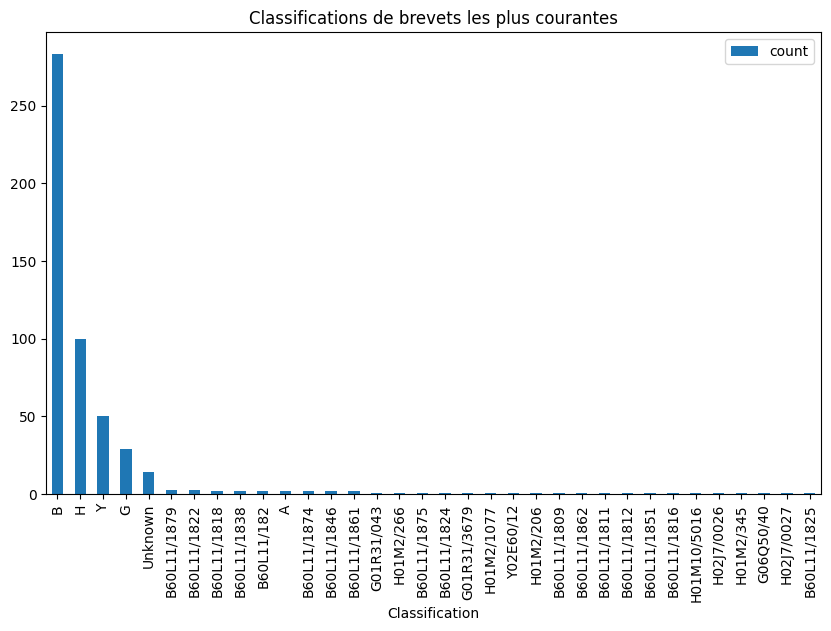

In [10]:
# Analyser les classifications de brevets les plus courantes en utilisant la vue
classifications_populaires = spark.sql("SELECT Classification, COUNT(*) AS count FROM GP GROUP BY Classification ORDER BY count DESC")

# Afficher le résultat
classifications_populaires.show()

# Visualisation (vous pouvez utiliser un diagramme à barres ou un nuage de mots)
classifications_populaires_df = classifications_populaires.toPandas()
classifications_populaires_df.plot(kind='bar', x='Classification', y='count', figsize=(10, 6), title='Classifications de brevets les plus courantes')

## Analyse des inventeurs et des assignataires les plus prolifiques

+-------------------+-----+
|          Inventors|count|
+-------------------+-----+
|  Albert S. Penilla|    5|
|   Angel A. Penilla|    5|
|          貴博 木下|    4|
| Takahiro Kinoshita|    4|
|          貴博 木下|    4|
|  Kevin I. Bertness|    3|
|               吴潇|    3|
|             毛玉龙|    3|
|             吴建中|    3|
|               毛磊|    3|
|             章亚辉|    3|
|               杨云|    3|
|             朱李俊|    3|
|               章程|    3|
|             王国辉|    3|
|             黄星星|    3|
|             冯卫良|    3|
|               陈裕|    3|
|             王昊旻|    3|
|             张玉成|    3|
+-------------------+-----+
only showing top 20 rows



<AxesSubplot: title={'center': 'Inventeurs les plus prolifiques'}, xlabel='Inventors'>

C:\Users\amezi\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 36020 (\N{CJK UNIFIED IDEOGRAPH-8CB4}) missing from current font.
  func(*args, **kwargs)
C:\Users\amezi\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 21338 (\N{CJK UNIFIED IDEOGRAPH-535A}) missing from current font.
  func(*args, **kwargs)
C:\Users\amezi\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26408 (\N{CJK UNIFIED IDEOGRAPH-6728}) missing from current font.
  func(*args, **kwargs)
C:\Users\amezi\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from current font.
  func(*args, **kwargs)
C:\Users\amezi\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 27611 (\N{CJK UNIFIED IDEOGRAPH-6BDB}) missing from current font.
  func(*args, **kwargs)
C:\Users\amezi\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 29577 (\N{CJK UN

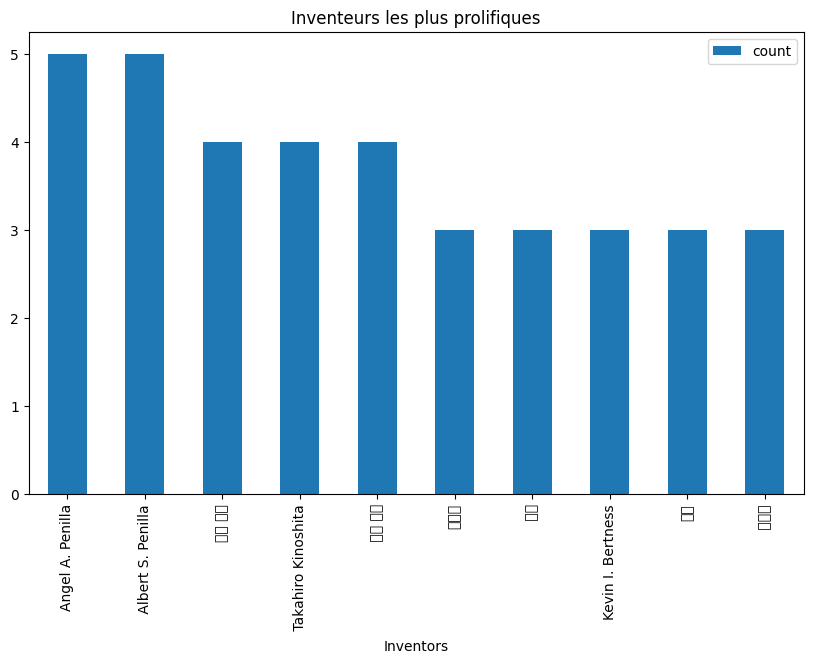

In [13]:
from pyspark.sql.functions import split, explode

# Créer une vue temporaire à partir du DataFrame
df.createOrReplaceTempView("brevets")

# Séparer les noms d'inventeurs et compter le nombre de brevets pour chaque inventeur
inventeurs_prolifiques = spark.sql("""
    SELECT explode(split(Inventors, ',')) AS Inventors, COUNT(*) AS count
    FROM brevets
    GROUP BY Inventors
    ORDER BY count DESC
""")

# Afficher le résultat
inventeurs_prolifiques.show()

# Visualisation (vous pouvez utiliser un diagramme à barres)
inventeurs_prolifiques_df = inventeurs_prolifiques.toPandas()
inventeurs_prolifiques_df.head(10).plot(kind='bar', x='Inventors', y='count', figsize=(10, 6), title='Inventeurs les plus prolifiques')


## Analyse de la disponibilité des brevets

+--------------------+-----+
|              Status|count|
+--------------------+-----+
|              Active|  344|
|             Unknown|   56|
|             Pending|   42|
|Expired - Fee Rel...|   41|
|             Granted|   26|
|           Withdrawn|    5|
|  Expired - Lifetime|    2|
+--------------------+-----+



<AxesSubplot: title={'center': 'Répartition des états des brevets'}, ylabel='count'>

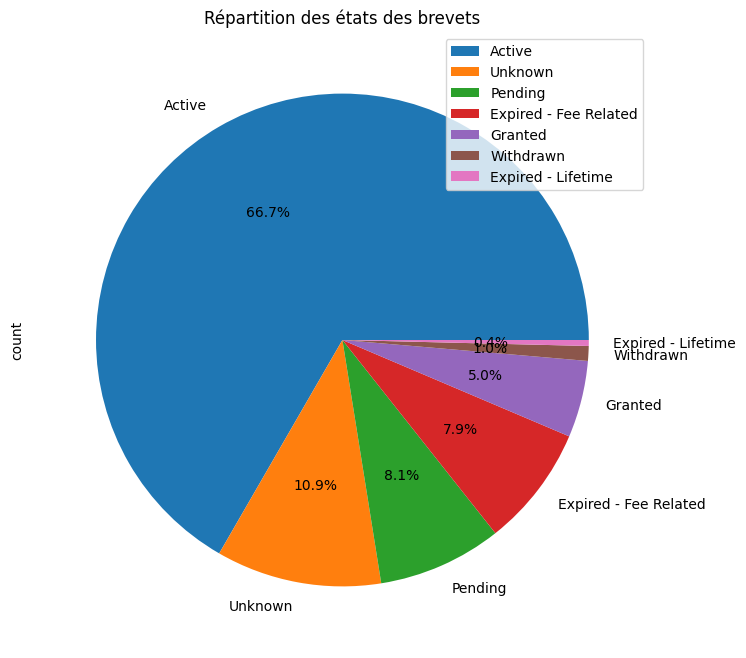

In [14]:
# Examiner l'état des brevets en utilisant la vue
etat_brevets = spark.sql("SELECT Status, COUNT(*) AS count FROM brevets GROUP BY Status ORDER BY count DESC")

# Afficher le résultat
etat_brevets.show()

# Visualisation (vous pouvez utiliser un diagramme à secteurs)
etat_brevets_df = etat_brevets.toPandas()
etat_brevets_df.plot(kind='pie', y='count', labels=etat_brevets_df['Status'], autopct='%1.1f%%', figsize=(8, 8), title='Répartition des états des brevets')


## Analyse de la collaboration entre les inventeurs ou les assignataires

In [15]:
from pyspark.sql.functions import split, explode

# Séparer les noms d'inventeurs et compter le nombre de brevets pour chaque paire d'inventeurs
inventors_df1 = spark.sql("""
    SELECT explode(split(Inventors, ',')) AS Inventor1, `Patent ID`
    FROM GP
""")

inventors_df2 = spark.sql("""
    SELECT explode(split(Inventors, ',')) AS Inventor2, `Patent ID`
    FROM GP
""")

# Joindre les deux DataFrames pour obtenir toutes les paires d'inventeurs travaillant sur le même brevet
pairs_inventors = inventors_df1.join(inventors_df2, inventors_df1['Patent ID'] == inventors_df2['Patent ID']).select(inventors_df1['Inventor1'], inventors_df2['Inventor2'], inventors_df1['Patent ID'])

# Filtrer les paires d'inventeurs travaillant ensemble sur plus d'un brevet
pairs_counts = pairs_inventors.groupBy("Inventor1", "Inventor2").count().filter("count > 1")

# Afficher les noms de ces brevets
pairs_counts.show(25)


+--------------------+--------------------+-----+
|           Inventor1|           Inventor2|count|
+--------------------+--------------------+-----+
|                逄昊|                尹豪|    4|
|                申明|                高青|    4|
|              卢兰光|              李建秋|    2|
|                吴潇|                杨云|    5|
|  Kyle Matthew Foley|   Bryan Emrys Booth|    2|
|              何向明|                潘岳|    4|
|                陈爽|                陈爽|    2|
|  Kenneth J. Jackson|  Kenneth J. Jackson|    2|
|                刘爽|              黄红波|    4|
|              黄星星|              冯卫良|    5|
|              卢兰光|              郑思奇|    4|
|                张干|                张干|    4|
|                叶倩|              李岐植|    4|
|              肖翔宇|              王亚楠|    4|
|              雷宗坤|              李广含|    4|
|              윤태봉|              윤태봉|    2|
|              路高磊|                刘阳|    4|
|              朱李俊|                章程|    5|
|              黄星星|            

## Analyse NLP

### Les mots les plus fréquents dans les titres 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amezi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


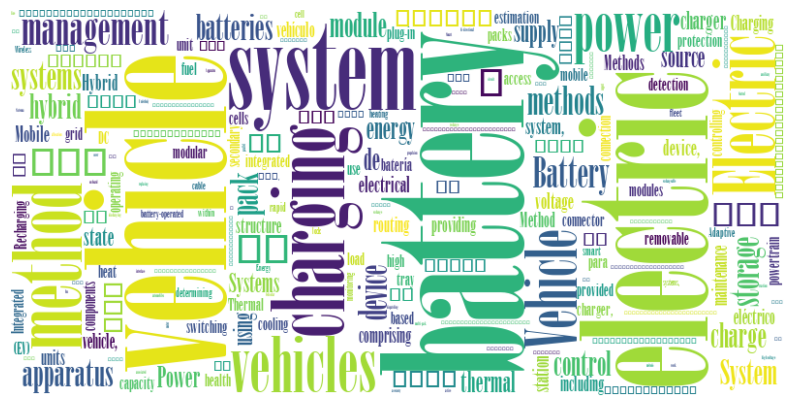

In [45]:
import matplotlib.font_manager as fm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode, split, regexp_replace
import nltk
from nltk.corpus import stopwords

# Télécharger la liste de mots vides (stop words) de nltk
nltk.download('stopwords')

# Liste de mots vides (stop words) à partir de nltk
stop_words = set(stopwords.words('english'))

# Nettoyer les titres pour supprimer les sauts de ligne et les mots vides
cleaned_df = df.withColumn("cleaned_title", split(regexp_replace(col("title"), "\n", " "), " ")) \
               .select(explode(col("cleaned_title")).alias("word")) \
               .filter((col("word") != '') & (~col("word").isin(stop_words)))

# Compter la fréquence des mots
word_counts = cleaned_df.groupBy("word").count()

# Convertir le DataFrame Spark en DataFrame pandas
word_counts_pandas = word_counts.toPandas()

# Créer une instance de WordCloud en utilisant une police de caractères prête à l'emploi
wordcloud = WordCloud(width=800, height=400, background_color='white', prefer_horizontal=0.9,
                      font_path=fm.findSystemFonts(fontpaths=None, fontext='ttf')[0]).generate_from_frequencies(
    dict(zip(word_counts_pandas['word'], word_counts_pandas['count'])))

# Afficher le nuage de mots
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


### Les mots les plus fréquents dans les abstracts

In [17]:
# Import des bibliothèques nécessaires
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Téléchargement des stopwords de NLTK (si vous ne l'avez pas déjà fait)
nltk.download('stopwords')
nltk.download('punkt')

# Liste des stopwords en français
stop_words = set(stopwords.words('english'))

# Tokenisation et comptage des mots dans tous les abstracts
word_counts = Counter()
#df_cleaned=df_cleaned.toPandas()


# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df.toPandas()
# Remplacez 'df_cleaned' par le nom de votre DataFrame si nécessaire
for abstract in df_pandas['Abstract']:
    # Tokenisation des mots
    tokens = word_tokenize(abstract)
    # Suppression des stopwords et des mots courts
    tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words and len(word) > 2]
    # Mise à jour du compteur
    word_counts.update(tokens)

# Affichage des 10 mots les plus fréquents
print("Les 20 mots les plus fréquents dans les abstracts sont :")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amezi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amezi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Les 10 mots les plus fréquents dans les abstracts sont :
battery: 929
vehicle: 512
electric: 371
power: 321
system: 284
charging: 278
first: 184
includes: 182
charge: 151
second: 150
one: 148
configured: 135
voltage: 135
electrical: 133
control: 126
배터리: 124
energy: 123
device: 122
unit: 122
pack: 116


In [ ]:
#Similarité entre les brevets par description et abstract 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Prétraitement des données

# Vectorisation des abstracts avec TF-IDF
vectorizer_abstract = TfidfVectorizer(stop_words='english')
tfidf_matrix_abstract = vectorizer_abstract.fit_transform(df_pandas['Abstract'])

# Vectorisation des descriptions avec TF-IDF
vectorizer_description = TfidfVectorizer(stop_words='english')
tfidf_matrix_description = vectorizer_description.fit_transform(df_pandas['Description'])

# Calcul de la similarité cosinus entre les abstracts
similarities_abstract = cosine_similarity(tfidf_matrix_abstract, tfidf_matrix_abstract)

# Calcul de la similarité cosinus entre les descriptions
similarities_description = cosine_similarity(tfidf_matrix_description, tfidf_matrix_description)

# Affichage des paires de brevets les plus similaires pour les abstracts
# Par exemple, afficher les 5 paires de brevets les plus similaires
print("Similarité entre les abstracts :")
top_n = 5
for i in range(len(df_pandas)):
    print(f"Brevet {i+1}:")
    similar_indices = similarities_abstract[i].argsort()[-top_n-1:-1][::-1]
    for j in similar_indices:
        if j != i:
            print(f"   - Brevet {j+1}: Similarité = {similarities_abstract[i][j]}")

# Affichage des paires de brevets les plus similaires pour les descriptions
# Par exemple, afficher les 5 paires de brevets les plus similaires
print("\nSimilarité entre les descriptions :")
for i in range(len(df_cleaned)):
    print(f"Brevet {i+1}:")
    similar_indices = similarities_description[i].argsort()[-top_n-1:-1][::-1]
    for j in similar_indices:
        if j != i:
            print(f"   - Brevet {j+1}: Similarité = {similarities_description[i][j]}")


Similarité entre les abstracts :
Brevet 1:
   - Brevet 328: Similarité = 0.36721005212274094
   - Brevet 376: Similarité = 0.34389252776999757
   - Brevet 143: Similarité = 0.27560776722687047
   - Brevet 140: Similarité = 0.27560776722687047
   - Brevet 5: Similarité = 0.2705435925095331
Brevet 2:
   - Brevet 123: Similarité = 0.4716610565272371
   - Brevet 58: Similarité = 0.3505600999217026
   - Brevet 288: Similarité = 0.33760360770516984
   - Brevet 328: Similarité = 0.33200741484683266
   - Brevet 352: Similarité = 0.29963397452122953
Brevet 3:
   - Brevet 367: Similarité = 0.4956793965579908
   - Brevet 312: Similarité = 0.32910100009325904
   - Brevet 357: Similarité = 0.31175501123266286
   - Brevet 237: Similarité = 0.2889615443518823
   - Brevet 7: Similarité = 0.28587271872459036
Brevet 4:
   - Brevet 516: Similarité = 0.0
   - Brevet 170: Similarité = 0.0
   - Brevet 176: Similarité = 0.0
   - Brevet 175: Similarité = 0.0
   - Brevet 174: Similarité = 0.0
Brevet 5:
   - Br

NameError: name 'df_cleaned' is not defined

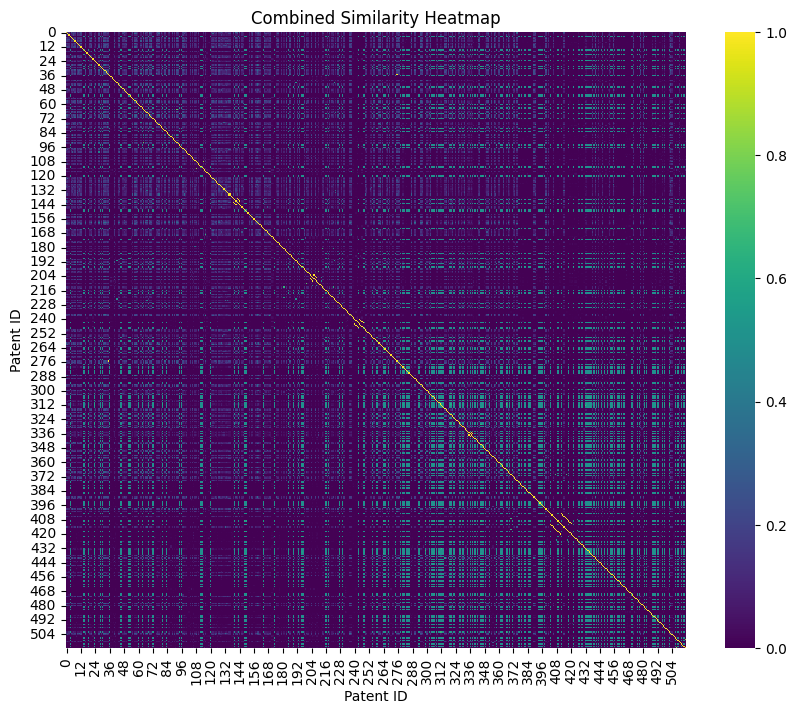

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Define a function to plot heatmaps
def plot_heatmap(similarities, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarities, cmap='viridis', annot=False)
    plt.title(title)
    plt.xlabel('Patent ID')
    plt.ylabel('Patent ID')
    plt.show()

# Combine the similarity matrices
combined_similarity = (similarities_abstract + similarities_description) / 2

# Plot heatmap for combined similarity
plot_heatmap(combined_similarity, 'Combined Similarity Heatmap')


In [30]:
# Define a threshold for similarity
threshold = 0.6  # Adjust this threshold as needed

# Find similar pairs based on combined similarity
similar_pairs = np.argwhere(combined_similarity > threshold)

# Print similar pairs
print("Highly Similar Patents:")
for pair in similar_pairs:
    if pair[0] != pair[1]:
        print(f"Patent {pair[0]+1} and Patent {pair[1]+1}")


Highly Similar Patents:
Patent 1 and Patent 2
Patent 1 and Patent 3
Patent 1 and Patent 5
Patent 1 and Patent 6
Patent 1 and Patent 7
Patent 1 and Patent 8
Patent 1 and Patent 9
Patent 1 and Patent 10
Patent 1 and Patent 11
Patent 1 and Patent 12
Patent 1 and Patent 13
Patent 1 and Patent 17
Patent 1 and Patent 20
Patent 1 and Patent 21
Patent 1 and Patent 22
Patent 1 and Patent 23
Patent 1 and Patent 24
Patent 1 and Patent 25
Patent 1 and Patent 27
Patent 1 and Patent 28
Patent 1 and Patent 30
Patent 1 and Patent 32
Patent 1 and Patent 33
Patent 1 and Patent 34
Patent 1 and Patent 35
Patent 1 and Patent 36
Patent 1 and Patent 38
Patent 1 and Patent 40
Patent 1 and Patent 41
Patent 1 and Patent 42
Patent 1 and Patent 43
Patent 1 and Patent 44
Patent 1 and Patent 45
Patent 1 and Patent 48
Patent 1 and Patent 49
Patent 1 and Patent 50
Patent 1 and Patent 51
Patent 1 and Patent 55
Patent 1 and Patent 56
Patent 1 and Patent 57
Patent 1 and Patent 58
Patent 1 and Patent 59
Patent 1 and Pate

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

